## Setup

In [9]:
import os
import sys

import numpy as np
import pandas as pd

import paths
import pickle
import importlib

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [10]:
# A helper function to add lags to the input dataset
def add_lags_inputs(inputs, num_months_lags):
    inputs = inputs.copy(deep = True)
    
    for field in inputs:
        #for i in range(min(1, num_months_lag + 1), max(1, num_months_lag+1)):
        for i in num_months_lags:
                inputs[f'{field}_lag{i}'] = inputs[field].shift(time = i)

    return inputs

In [11]:
# A helper function to format RAPID in the same way as the other output streamfunctions for training
def format_RAPID(RAPID_path):
    
    PSI_RAPID = xr.open_dataset(RAPID_path)

    PSI_RAPID['depth'] = - PSI_RAPID['depth']
    PSI_RAPID = (PSI_RAPID
                 .rename({'depth': 'Z'})
                 .rename_vars({'stream_function_mar': 'psi_moc'})
                 .assign_coords(k=('k', np.arange(len(PSI_RAPID.depth.values)))))

    PSI_RAPID['psi_moc'] = (('k', 'time'), PSI_RAPID['psi_moc'].values)
    PSI_RAPID['psi_moc'] = PSI_RAPID['psi_moc'].expand_dims({'latitude': [26.5], 'longitude': [0.0]})
    return PSI_RAPID

In [12]:
# A helper function to extract the streamfunction at the level (depth or density) where the moc is maximal in a southern (max) or northern direction (min)
def get_PSI_at_max_density_level(PSI, moc_param="psi_moc", max=True):
    PSI_mean = PSI[moc_param].mean("time")  # np.abs()
    if max is True:
        max_index = PSI_mean.argmax(dim="k")
    else:
        max_index = PSI_mean.argmin(dim="k")
    return PSI.isel(k=max_index)

In [13]:
# A helper function to format the input files based on a given latitude
def format_lat_lon(value):
    """Format latitude or longitude with N/S or E/W suffix."""
    if value < 0:
        return f"{abs(value)}S"
    else:
        return f"{value}N"

In [14]:
# A wrapper class for stats models lin reg to facilitate sklearn grid search
class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=0.1, L1_wt=0.1):
        self.alpha = alpha
        self.L1_wt = L1_wt
        self.model = None

    def fit(self, X, y):
        self.model = sm.OLS(y, X).fit_regularized(alpha=self.alpha, L1_wt=self.L1_wt)
        return self

    def predict(self, X):
        return self.model.predict(X)

## Experiment variables

In [15]:
data_home = paths.LOCAL_DIR

# We are specifically interested in the atlantic mask at 30S 
lat = -30
atlantic_lon_min = -50
atlantic_lon_max = 17

RAPID_path = os.path.join(paths.RAPID_ARRAY, "moc_vertical.nc")
strf_path = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}_atlantic_sf_depth.pickle"
depth_path = f"{data_home}/ecco_data_minimal/depth_range.pickle"

# MISCELLANEOUS (for Linear Regression)
verbose = True
mape_thresh = 0.5
cross_val_folds = 4
param_grid_levels = 2

## Loading and preprocessing relevant data

In [16]:
xr.open_dataset(RAPID_path)

<xarray.Dataset>
Dimensions:              (time: 13057, depth: 307)
Coordinates:
  * time                 (time) datetime64[ns] 2004-04-02 ... 2022-02-15
  * depth                (depth) float64 0.0 19.87 39.74 ... 5.976e+03 5.995e+03
Data variables:
    stream_function_mar  (depth, time) float64 ...
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...

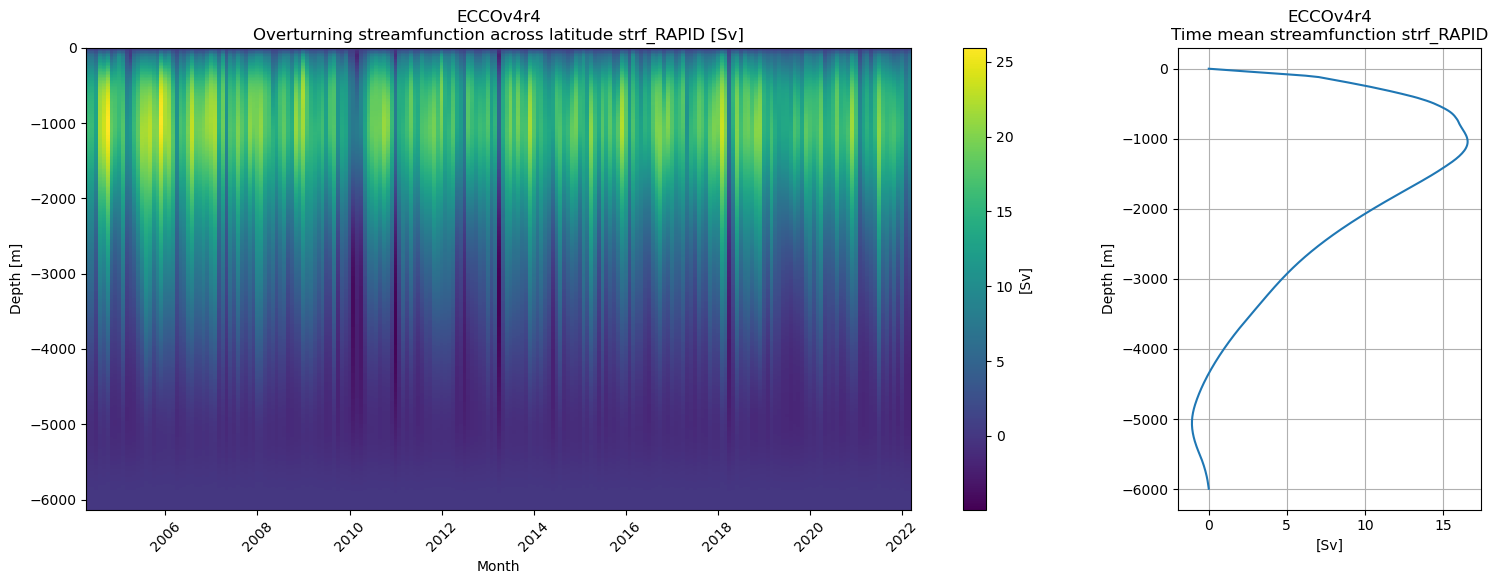

In [17]:
# Prepare the input RAPID streamfunction and resample to monthly mean values
PSI_RAPID = format_RAPID(RAPID_path).resample(time='1ME').mean()

RAPID_inputs = get_PSI_at_max_density_level(
                    PSI_RAPID, moc_param='psi_moc', max=True
                ).drop_vars('Z')
RAPID_all_inputs = add_lags_inputs(RAPID_inputs, range(120))    

plot_depth_stf_vs_time(stf_ds=PSI_RAPID.squeeze(), label='strf_RAPID', param='psi_moc')

In [18]:
# Prepare the input surface variables at 30S and clip them according to the atlantic basin mask
inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}.nc").isel(latitude=slice(1,2))
inputs = inputs.sel(longitude=slice(atlantic_lon_min, atlantic_lon_max))
inputs

<xarray.Dataset>
Dimensions:    (time: 312, latitude: 1, longitude: 134)
Coordinates:
  * latitude   (latitude) float32 -29.75
  * longitude  (longitude) float32 -49.75 -49.25 -48.75 ... 15.75 16.25 16.75
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 ...
    ZWS        (time, latitude, longitude) float32 ...
    OBP        (time, latitude, longitude) float32 ...
    SSS        (time, latitude, longitude) float32 ...
    SST        (time, latitude, longitude) float32 ...

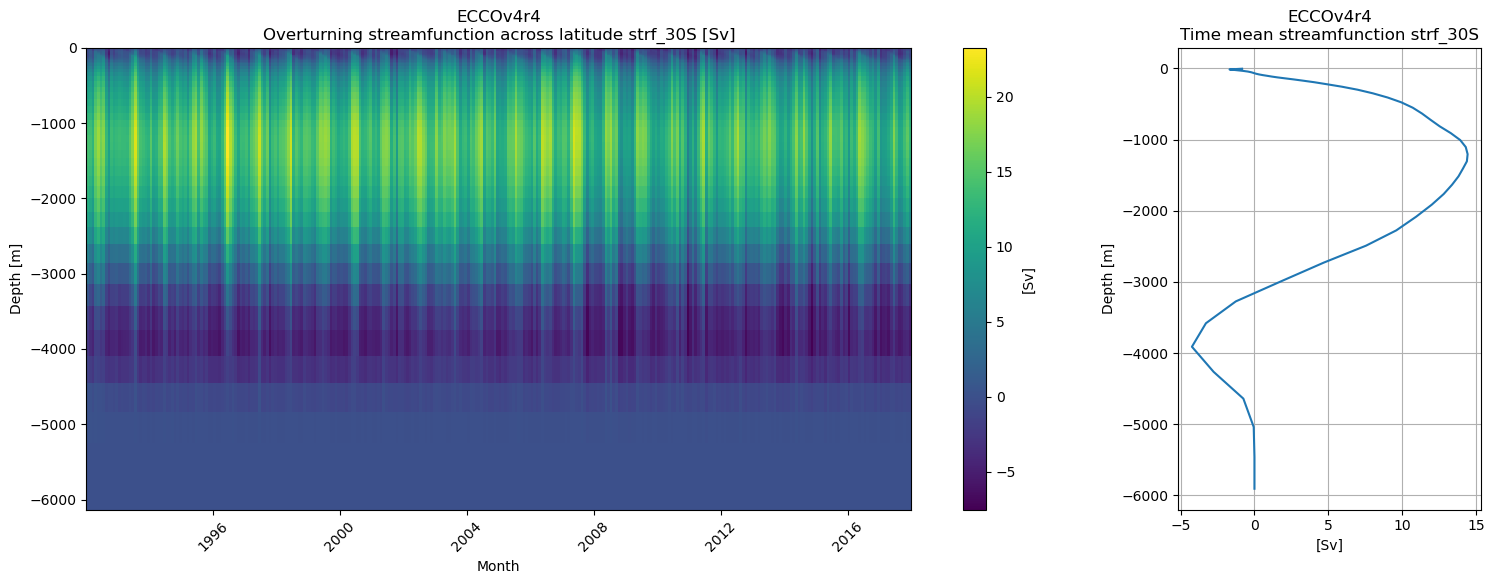

In [19]:
# Retrieve the output 30S streamfunction and calculate the moc strenght in the upper and lower cell
with open(strf_path, 'rb') as f:
    strf = pickle.load(f).astype(np.float64)[::-1] #Invert the depth values

strf = np.expand_dims(strf[:, 1, :], 1) # grabbing just 30S
strf = np.transpose(strf, (2,0,1))
    
strf = xr.Dataset(
        data_vars = {'moc' : (["time", "k", "latitude"], strf)}, 
        coords = {'time' : inputs.time,  'k': np.arange(50), 'latitude' : np.atleast_1d(-60)}
        )
ECCO_GRID = xr.open_dataset(paths.geom_fp)
strf = strf.assign_coords(Z=('k', ECCO_GRID.coords['Z'].data))

outputs_upper_cell = get_PSI_at_max_density_level(strf.squeeze(), moc_param='moc', max=True)
outputs_bottom_cell = get_PSI_at_max_density_level(strf.squeeze(), moc_param='moc', max=False)

plot_depth_stf_vs_time(stf_ds=strf.squeeze(), label='strf_30S', param='moc')

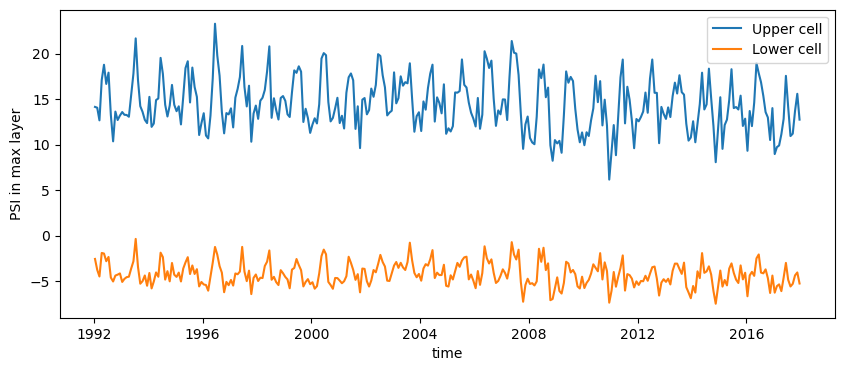

In [20]:
# Plot both streamfunctions for a sanity check
plt.figure(figsize = (10, 4))
plt.plot(outputs_upper_cell["time"].squeeze(), outputs_upper_cell["moc"].squeeze(), label='Upper cell')   
plt.plot(outputs_bottom_cell["time"].squeeze(), outputs_bottom_cell["moc"].squeeze(), label='Lower cell') 
plt.xlabel('time')
plt.ylabel('PSI in max layer')
plt.legend()

In [21]:
# Decide which covariates and output to use 
outputs = outputs_bottom_cell

psi_moc_variable = "psi_moc"                   #Can be normal 'psi_moc' or any other lag defined above
RAPID_inputs = RAPID_all_inputs[[psi_moc_variable]]

In [22]:
def clip_dates(RAPID_inputs, inputs, full_outputs):

    # RAPID has the latest start date and the ECCO data has the earliest end date (combine)
    date_range = (RAPID_inputs.dropna(dim='time', how='any').time.values[0], inputs.time.values[-1]) 
    date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
    #print('Date range to align to:', date_range)

    # Align the surface variable inputs with RAPID, then align the in- and outputs
    inputs, RAPID_inputs = align_inputs_outputs(inputs, RAPID_inputs, date_range = date_range, ecco=False)
    inputs, outputs = align_inputs_outputs(inputs, full_outputs, date_range = date_range, ecco=False)
    return inputs, RAPID_inputs, outputs

In [23]:
def preprocess_inputs(RAPID_inputs, inputs, psi_moc_variable, history=1, mode='combined'):
    # Preprocess both surface variables as the RAPID input data
    pp_data_RAPID = apply_preprocessing(RAPID_inputs,
                                    mode="inputs",
                                    remove_season=False,
                                    remove_trend=False,
                                    standardize=True,
                                    lowpass=False)

    pp_data_surface = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=False,
                              remove_trend=False,
                              standardize=True,
                              lowpass=False)
    
    coords = ["time"] # or "longitude"

    # reshape as desired and convert to a numpy array
    pp_data_RAPID_np = reshape_inputs(pp_data_RAPID, history=history, keep_coords=coords, data_vars=[psi_moc_variable], verbose=False)
    pp_data_SURFACE_np = reshape_inputs(pp_data_surface, history=history, keep_coords=coords, data_vars=["OBP", "ZWS"], verbose=False) #keep longitude for training special 

    # Concatenate the different information layers together
    if mode == 'RAPID':
        return  pp_data_RAPID_np
    elif mode == 'surface variables':
        return pp_data_SURFACE_np
    elif mode == 'combined':
        return np.concatenate((pp_data_RAPID_np, pp_data_SURFACE_np), axis=-1)

In [24]:
def preprocess_outputs(outputs, X):
    # MOC strength preprocessing
    strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=False,
                               remove_trend=False,
                               standardize=False,
                               lowpass=False)
    strength_np = strength.moc.squeeze().values
    y = strength_np[-X.shape[0]:]
    return X, y

In [25]:
def get_input(lag_index, RAPID_all_inputs, inputs, mode='combined', history=1, cell='bottom'):

    # Decide which covariates and output to use 
    if cell == 'bottom':
        full_outputs = outputs_bottom_cell
    else:
        full_outputs = outputs_upper_cell

    psi_moc_variable = f"psi_moc_lag{lag_index}"    #Can be normal 'psi_moc' or any other lag defined above
    RAPID_inputs = RAPID_all_inputs[[psi_moc_variable]]

    inputs, RAPID_inputs, outputs = clip_dates(RAPID_inputs, inputs, full_outputs)
    X = preprocess_inputs(RAPID_inputs, inputs, psi_moc_variable, history, mode)
    X, y = preprocess_outputs(outputs, X)
    
    # add bias term for linear regression
    X = X.squeeze()
    X = sm.add_constant(X)
    
    print(X.shape)
    print(y.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, stratify=None, random_state=123456)

    device = "cuda" if t.cuda.is_available() else "cpu"
    
    return X, y, X_train, y_train, X_test, y_test

## Running Linear Regression

In [26]:
def perform_lr(X_train, y_train, X_test, y_test):

    # hyperparameters to optimise
    param_grid = {
        "alpha": np.logspace(-4, 4, 10),
        "L1_wt": np.linspace(0, 1, 10)
    }

    # grid search - 10-fold cross-validation
    grid_search = GridSearchCV(SMWrapper(), param_grid, cv=10, scoring="neg_mean_squared_error")
    grid_search.fit(X_train, y_train)

    # report best result
    #print(f"Best MSE (cross-validation): {round(-grid_search.best_score_, 3)}")

    #  calculate test performance and optionally report
    y_pred = grid_search.best_estimator_.predict(X_test)
    y_pred_train = grid_search.best_estimator_.predict(X_train)
    metric_dict = {}
    
    metric_dict['R^2'] = round(r2_score(y_test, y_pred), 3)
    metric_dict['MSE'] = round(mean_squared_error(y_test, y_pred), 3)
    metric_dict['RMSE'] = round(root_mean_squared_error(y_test, y_pred), 3)
    metric_dict['MAE'] = round(mean_absolute_error(y_test, y_pred), 3)
    metric_dict['MAPE'] = round(mean_absolute_percentage_error(y_test, y_pred) * 100, 3)
    metric_dict['train_corr'] = round(np.corrcoef(np.array(y_pred_train).squeeze(), y_train)[0, 1], 3)
    metric_dict['test_corr'] = round(np.corrcoef(np.array(y_pred).squeeze(), y_test)[0, 1], 3)

    #  calculating custom MAPE to ignore the smallest observed MOC values
    mape, num_discard = custom_MAPE(y_test, y_pred, threshold = mape_thresh, return_num_discarded = True)
    pct_kept = round((len(y_test) - num_discard) / len(y_test) * 100, 3)
    metric_dict['MAPE_thresh'] = round(mape * 100, 3)

    if verbose:
        metrics_series = pd.Series(metric_dict)
        metrics_df = metrics_series.to_frame(name='Value')
    return grid_search, metric_dict

In [27]:
def predict_lr(grid_search, X_train, X_test):
    train_set_pred = grid_search.best_estimator_.predict(X_train)
    test_set_pred = grid_search.best_estimator_.predict(X_test)
    all_preds = np.concatenate([train_set_pred, test_set_pred])
    return all_preds

In [28]:
# To loop over several models and compare the performances
grids = []
metrics = []
preds = []
for i in range(120):
    X, y, Xt_train, Yt_train, Xt_test, Yt_test = get_input(i, RAPID_all_inputs, inputs, mode='combined')
    grid, metric_dict = perform_lr(Xt_train, Yt_train, Xt_test, Yt_test)
    pred = predict_lr(grid, Xt_train, Xt_test)
    grids.append(grid)
    metrics.append(metric_dict)
    preds.append(pred)

(164, 4)
(164,)
(163, 4)
(163,)
(162, 4)
(162,)
(161, 4)
(161,)
(160, 4)
(160,)
(159, 4)
(159,)
(158, 4)
(158,)
(157, 4)
(157,)
(156, 4)
(156,)
(155, 4)
(155,)
(154, 4)
(154,)
(153, 4)
(153,)
(152, 4)
(152,)
(151, 4)
(151,)
(150, 4)
(150,)
(149, 4)
(149,)
(148, 4)
(148,)
(147, 4)
(147,)
(146, 4)
(146,)
(145, 4)
(145,)
(144, 4)
(144,)
(143, 4)
(143,)
(142, 4)
(142,)
(141, 4)
(141,)
(140, 4)
(140,)
(139, 4)
(139,)
(138, 4)
(138,)
(137, 4)
(137,)
(136, 4)
(136,)
(135, 4)
(135,)
(134, 4)
(134,)
(133, 4)
(133,)
(132, 4)
(132,)
(131, 4)
(131,)
(130, 4)
(130,)
(129, 4)
(129,)
(128, 4)
(128,)
(127, 4)
(127,)
(126, 4)
(126,)
(125, 4)
(125,)
(124, 4)
(124,)
(123, 4)
(123,)
(122, 4)
(122,)
(121, 4)
(121,)
(120, 4)
(120,)
(119, 4)
(119,)
(118, 4)
(118,)
(117, 4)
(117,)
(116, 4)
(116,)
(115, 4)
(115,)
(114, 4)
(114,)
(113, 4)
(113,)
(112, 4)
(112,)
(111, 4)
(111,)
(110, 4)
(110,)
(109, 4)
(109,)
(108, 4)
(108,)
(107, 4)
(107,)
(106, 4)
(106,)
(105, 4)
(105,)
(104, 4)
(104,)
(103, 4)
(103,)
(102, 4)

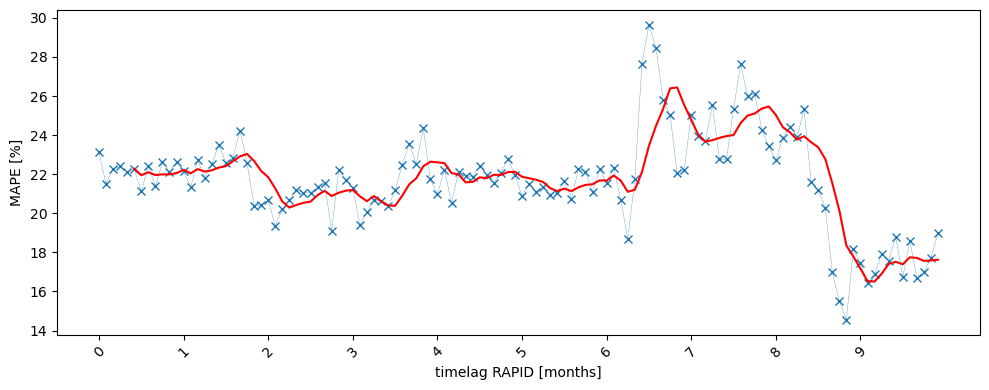

In [88]:
metrics_df_RAPID = pd.DataFrame(metrics)

# Plotting
rolling_mean = metrics_df_RAPID['MAPE'].rolling(window=6).mean()

plt.figure(figsize=(10, 4))  # Optional: specifies the figure size
plt.plot(metrics_df_RAPID.index, metrics_df_RAPID['MAPE'], marker='x', linestyle='--', linewidth=0.3)  
plt.plot(metrics_df_RAPID.index, rolling_mean, color='red')
plt.xlabel('timelag RAPID [months]')
plt.ylabel('MAPE [%]')
plt.xticks(np.arange(0, 120, 12), labels=[f'{i}' for i in range(10)], rotation=45) 
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.show()

In [55]:
metrics_df = pd.DataFrame(metrics)
summary_metrics_df = pd.DataFrame({
                "mean": metrics_df.mean().round(3), 
                "std": metrics_df.std().round(3)}
            )
display(summary_metrics_df)

,mean,std
R^2,0.435,0.123
MSE,0.671,0.181
RMSE,0.811,0.117
MAE,0.656,0.088
MAPE,16.544,3.058
train_corr,0.791,0.034
test_corr,0.768,0.028
MAPE_thresh,16.544,3.058


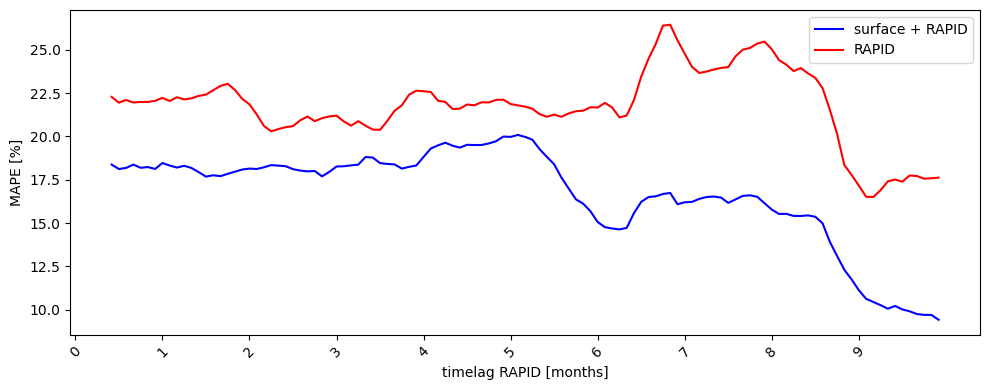

In [91]:
# Plotting
rolling_mean_orig = metrics_df['MAPE'].rolling(window=6).mean()
rolling_mean = metrics_df_RAPID['MAPE'].rolling(window=6).mean()

plt.figure(figsize=(10, 4))  # Optional: specifies the figure size
plt.plot(metrics_df.index, rolling_mean_orig, color='blue', label='surface + RAPID')
plt.plot(metrics_df_RAPID.index, rolling_mean, color='red', label='RAPID')
plt.xlabel('timelag RAPID [months]')
plt.ylabel('MAPE [%]')
plt.xticks(np.arange(0, 120, 12), labels=[f'{i}' for i in range(10)], rotation=45) 
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.legend()
plt.show()

In [2]:
# Plotting
rolling_mean = metrics_df['MAPE'].rolling(window=6).mean()

plt.figure(figsize=(10, 4))  # Optional: specifies the figure size
plt.plot(metrics_df.index, metrics_df['MAPE'], marker='x', linestyle='--', linewidth=0.3)  
plt.plot(metrics_df.index, rolling_mean, color='red')
plt.xlabel('timelag RAPID [months]')
plt.ylabel('MAPE [%]')
plt.xticks(np.arange(0, 122, 12), labels=[f'{i}' for i in range(11)], rotation=45) 
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.show()

NameError: name 'metrics_df' is not defined

In [66]:
pred[-1]

-5.69623599862651

## Output visualisation

axes: ['time', 'history', 'feature']
variables: ['psi_moc_lag60']
shape: (104, 1, 1)
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (104, 1, 2)
(104, 4)
(104,)
(104,)


,R^2,MSE,RMSE,MAE,MAPE,train_corr,test_corr,MAPE_thresh
0,0.420,0.840,0.917,0.735,18.297,0.834,0.734,18.297
1,0.429,0.815,0.903,0.724,17.967,0.840,0.737,17.966
2,0.436,0.805,0.897,0.724,17.994,0.836,0.724,17.993
3,0.424,0.821,0.906,0.738,18.272,0.834,0.722,18.272
4,0.392,0.822,0.907,0.731,18.526,0.833,0.742,18.525
...,...,...,...,...,...,...,...,...
115,0.487,0.389,0.623,0.515,9.831,0.820,0.719,9.831
116,0.631,0.280,0.529,0.443,8.948,0.765,0.814,8.948
117,0.545,0.345,0.587,0.483,9.280,0.779,0.765,9.280
118,0.559,0.354,0.595,0.489,9.418,0.771,0.779,9.418


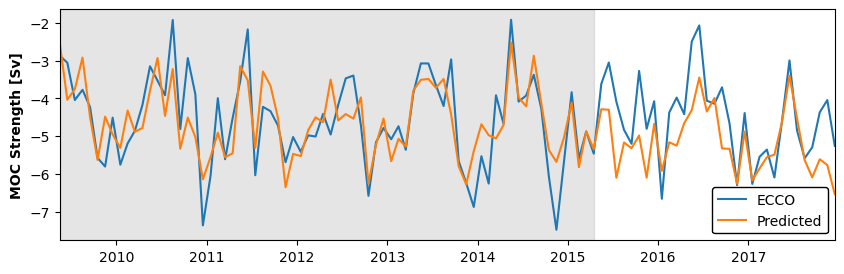

In [86]:
# Extracting all predictions in time order
X, y, Xt_train, Yt_train, Xt_test, Yt_test = get_input(60, RAPID_all_inputs, inputs)
grid, metric_dict = perform_lr(Xt_train, Yt_train, Xt_test, Yt_test)
pred = predict_lr(grid, Xt_train, Xt_test)

print(y.shape)

time = outputs.time.values[-len(X):]

display(metrics_df)

fig, ax = timeseries_comparison(pred, y, time, len(Xt_train))
plt.show()

In [84]:
RAPID_all_inputs

<xarray.Dataset>
Dimensions:         (time: 215, latitude: 1, longitude: 1)
Coordinates:
    k               (latitude, longitude) int32 53
  * latitude        (latitude) float64 26.5
  * longitude       (longitude) float64 0.0
  * time            (time) datetime64[ns] 2004-04-30 2004-05-31 ... 2022-02-28
Data variables: (12/121)
    psi_moc         (time, latitude, longitude) float64 16.24 15.94 ... 10.85
    psi_moc_lag0    (time, latitude, longitude) float64 16.24 15.94 ... 10.85
    psi_moc_lag1    (time, latitude, longitude) float64 nan 16.24 ... 9.114
    psi_moc_lag2    (time, latitude, longitude) float64 nan nan ... 15.56 14.97
    psi_moc_lag3    (time, latitude, longitude) float64 nan nan ... 16.92 15.56
    psi_moc_lag4    (time, latitude, longitude) float64 nan nan ... 16.38 16.92
    ...              ...
    psi_moc_lag114  (time, latitude, longitude) float64 nan nan ... 17.5 15.97
    psi_moc_lag115  (time, latitude, longitude) float64 nan nan ... 8.477 17.5
    psi_moc_lag116  (time, latitude, longitude) float64 nan nan ... 11.96 8.477
    psi_moc_lag117  (time, latitude, longitude) float64 nan nan ... 13.41 11.96
    psi_moc_lag118  (time, latitude, longitude) float64 nan nan ... 17.69 13.41
    psi_moc_lag119  (time, latitude, longitude) float64 nan nan ... 15.29 17.69
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...

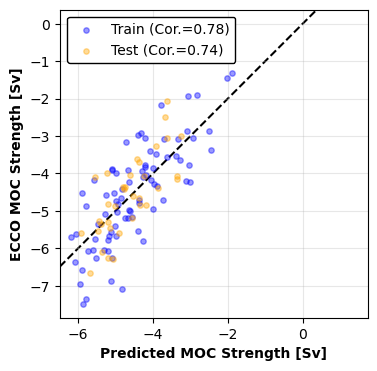

In [249]:
# Alternate view: looking at a scatterplot of predicted vs. actual
fig, ax = pred_vs_actual(train_set_pred, test_set_pred, y_train, y_test)
plt.show()